# 1. Focault test data reduction

This document will describe step by step the process of extracting the surface profile of a telescope mirror from Foucault or Wire test data.

## 1.1. Obtaining the mirror profile

Before jumping into the simulation, we need to find the model that will obtain the mirror surface profile from test data.
After that, we will perform a simulation with real world data.

### 1.1.1. Deriving the equations

First we need to derive the set of equations that will alow to obtaing the mirror surface profile from test data.

For a generic concave mirror surface, the Foucault or Wire tests will show for each mirror radius the equivalent radius of curvature it has. This can be interpreted as finding a succession of spherical surfaces that approximate the existing mirror surface (dashed curve in figure). Obviously that for a completely spherical mirror surface, there is exactly one sphere that matches the whole surface.

<img src="figures/diagram_1.svg" width="800"/>

The result of these tests is a set of data pairs consisting of mirror diameter $x$ (independent variable) and its respective radius of curvature $f(x)$ (dependent variable).

To help formulate the equations that model these tests, we can instead think of vectors $G(x)$ and $F(x)$ representing surface height respective to its center and radius of curvature respectively:

\begin{align}
G(x) = \langle x, g(x) \rangle \\
F(x) = \langle 0, f(x) \rangle
\end{align}

Subtracting the two vectors gives:

\begin{equation}
F(x) - G(x) = \langle 0 - x, f(x)-g(x) \rangle = \langle -x, f(x) - g(x) \rangle
\end{equation}

If we then represent the tangent vector to mirror surface at $G(x)$:

\begin{equation}
T(x) = \frac{G'(x)}{|G'(x)|} = \langle\frac{1}{|G'(x)|}, \frac{z'(x)}{|G'(x)|}\rangle
\end{equation}

Then it follows that:

\begin{align}
T(x) \cdot (F(x) - G(x)) = 0 \\
\left( - \frac{x}{|G'(x)|} + (f(x) - g(x))\frac{g'(x)}{|G'(x)|} \right) = 0\\
(f(x) - g(x))g'(x) = x
\end{align}

This results in the following differential equation:

\begin{equation}
g'(x) = \frac{x}{f(x) - g(x)}
\end{equation}

Knowing the data pairs $x$ and $f(x)$, we can integrate the equation above and get the mirror surface profile.

### 1.1.2. Finding a solution

Now in order to ... tbd Runge Kutta

### 1.1.3. Real world example

The real world collected data that will be used in this exercise is stored in a JSON file.

First we need to read the test data from the JSON file.

In [1]:
import json

with open('mirror_measurements_database.json', "r") as data_base_file:
    data_base = json.load(data_base_file)
    data_base_file.close()

diameter = data_base['diameter']
radius_of_curvature = data_base['radius_of_curvature_measurement']['radius_of_curvature']
measurements = sorted(data_base['measurements'], key=lambda m: m['optical_axis_offset'])

For convenience and to allow later use of the SciPy mathematical functions, we will first transform the data into Numpy arrays.

In [2]:
import pandas

measurements_data_frame = pandas.DataFrame(measurements)

display(measurements_data_frame) # Module display is part of library IPython

measurements_data_frame = measurements_data_frame.iloc[:,:2] # Remove the column containing the Foucault image captures

measurements_matrix = measurements_data_frame.to_numpy()
x = measurements_matrix[:, 1]
f = measurements_matrix[:, 0]

,optical_axis_offset,mirror_radius,foucaultgram
0,0.50,43.08,na.jpg
1,0.60,47.55,na.jpg
2,0.70,51.57,na.jpg
3,0.80,55.37,na.jpg
4,0.90,61.65,na.jpg
5,1.00,64.06,na.jpg
6,1.10,67.20,na.jpg
7,1.20,69.21,na.jpg
8,1.30,72.82,na.jpg
9,1.40,74.63,na.jpg


kjhkjhkh

In [3]:
import numpy
from scipy import interpolate

interpolate_f = interpolate.interp1d(x, f, kind="cubic")

num_samples = int((x[-1] - x[0])*2)

x_e = numpy.linspace(x[0], x[-1], num=num_samples)
f_e = interpolate_f(x_e)

kjhkhkjh

<IPython.core.display.Javascript object>


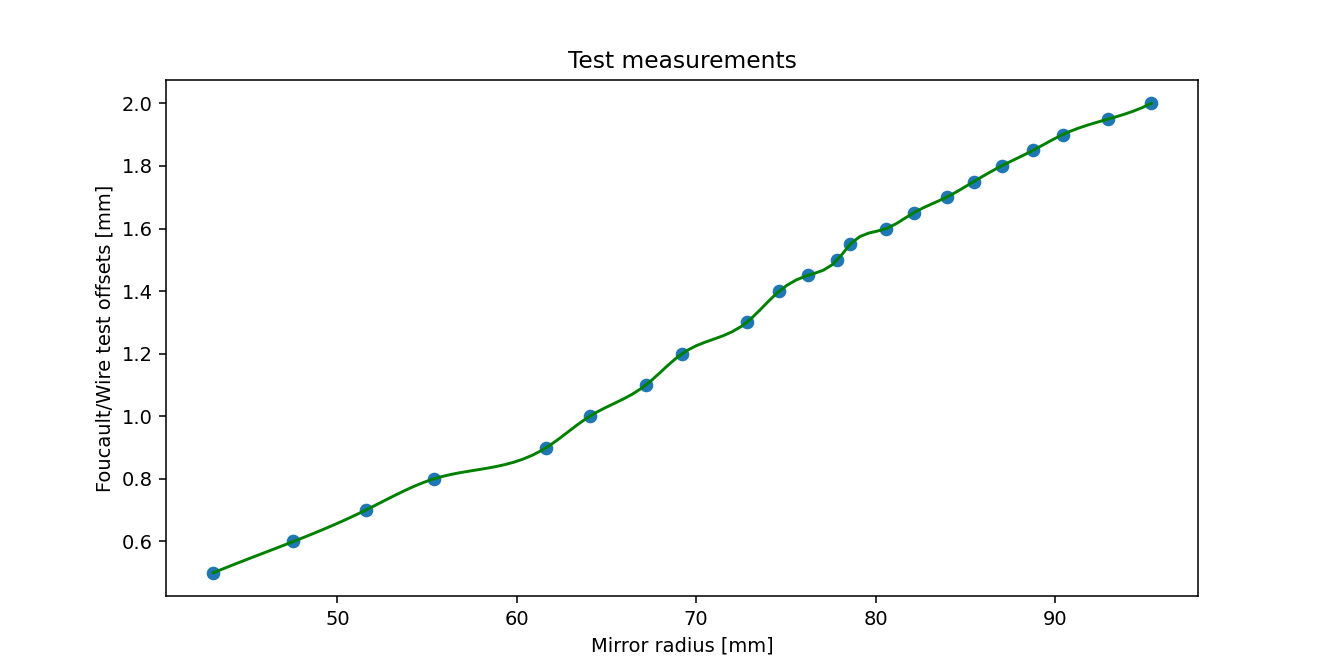

In [4]:
%matplotlib notebook
from matplotlib import pyplot

pyplot.title('Test measurements')
pyplot.scatter(x, f, label="Raw test data")
pyplot.plot(x_e, f_e, "g-", label="Raw test data (interpolated)")
pyplot.xlabel('Mirror radius [mm]')
pyplot.ylabel('Foucault/Wire test offsets [mm]')
pyplot.show()

In [5]:
from numba import jit

@jit(nopython=True)
def mirror_slope_ode_generic(x, f, g):
    dg = numpy.divide(x, numpy.subtract(f, g))
    return dg

def mirror_slope_ode(x, g):
    f_t = radius_of_curvature + interpolate_f(x)
    dg = mirror_slope_ode_generic(x, f_t, g)
    return dg

In [6]:
from scipy.integrate import solve_ivp

ode_solution = solve_ivp(fun=mirror_slope_ode,
                         t_span=[x_e[0], x_e[-1]],
                         y0=[0.0],
                         method="RK45",
                         t_eval=x_e,
                         vectorized=True,
                         dense_output=True)

g = numpy.reshape(ode_solution.y, (-1))

print(ode_solution.message)

The solver successfully reached the end of the integration interval.


fdgfdfg

<IPython.core.display.Javascript object>


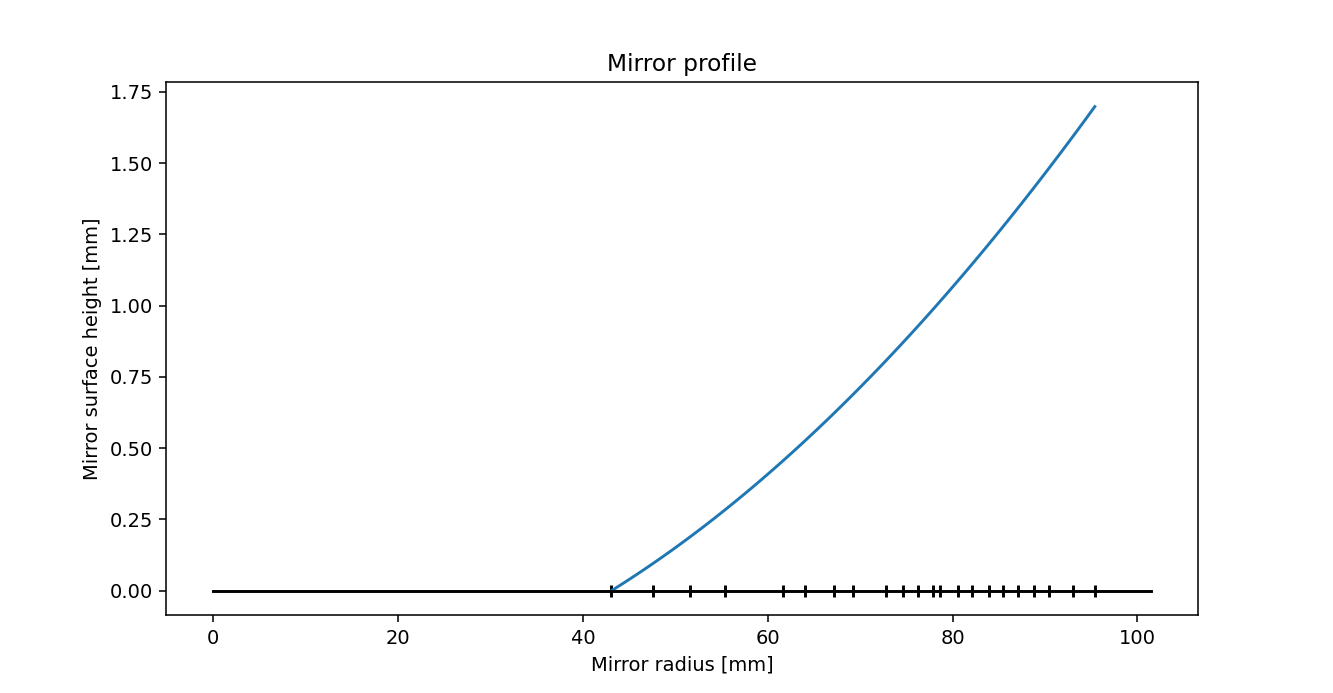

In [7]:
%matplotlib notebook
pyplot.title('Mirror profile')
pyplot.plot(x_e, g)
pyplot.plot([0.0, diameter/2], [0.0, 0.0], "k")
pyplot.scatter(x, numpy.zeros(x.size), c="k", marker="|")
pyplot.xlabel('Mirror radius [mm]')
pyplot.ylabel('Mirror surface height [mm]')
pyplot.show()

## 1.2. Finding the best fit conic curve

tbd ISO 10110 Part 12

\begin{equation}
g^*(x) = \frac{\frac{x^2}{R}}{1 + \sqrt{1 - (1 + k) \left(\frac{x}{R}\right)^2 } } + d
\end{equation}

tbd minimizing the RMS cost function

\begin{aligned}
RMS & = \frac{1}{\pi{r}^2} \int_{0}^{r} (g^{*}(x)-g(x))^2 \, 2\pi x \,dx \\
& = \frac{2}{r^2} \int_{0}^{r} (g^{*}(x)-g(x))^2 \, x \,dx \\
& \approx \frac{2}{r^2} \sum_{n=1}^{N} \left( \left(g^{*}(x_n)-g(x_n)\right)^2 \int_{\frac{x_{n}-x_{n-1}}{2}}^{\frac{x_{n+1}-x_{n}}{2}} x \,dx \right) \\
& = \frac{2}{r^2} \sum_{n=1}^{N} \left( \left(g^{*}(x_n)-g(x_n)\right)^2 \left(\frac{x^2}{2}\Big|_{\frac{x_{n}-x_{n-1}}{2}}^{\frac{x_{n+1}-x_{n}}{2}}\right)\right)
\end{aligned}
